# Trust in the Machine: How Contextual Factors and Personality Traits Shape Algorithm Aversion and Collaboration  - Notebook 1 / 3.

## Data Analysis

**Authors:**<br>
Vinicius Ferraz - Alfred-Weber Institute for Economics, University of Heidelberg <br>
Christiane Schwieren - Alfred-Weber Institute for Economics, University of Heidelberg <br>
Leon Houf - Alfred-Weber Institute for Economics, University of Heidelberg <br>
Thomas Pitz - Faculty of Society and Economics, Rhine-Waal University<br>
Jörn Sickmann -  Faculty of Society and Economics, Rhine-Waal University

This Jupyter Notebook contains the reproduction of the data analysis reported in the paper. In case of any questions, plese contact Vinicius Ferraz (visferraz@gmail.com). 

In [157]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu, kruskal, ranksums, friedmanchisquare, shapiro, pointbiserialr, ttest_ind
import scikit_posthocs as sp
import statsmodels.api as sm
import statsmodels.formula.api as smf
import warnings
import numpy as np
import matplotlib.ticker as ticker

%matplotlib inline

warnings.filterwarnings('ignore')

#### Data Parsing

In [92]:
df_experiment_1 = pd.read_csv('data/experiment_2023-02-24.csv') # experiment data, session 1
df_psych_1 = pd.read_csv('data/psych_2023-02-24.csv') # questionnaires data, session 1
df_experiment_2 = pd.read_csv('data/experiment_2023-02-27.csv') # experiment data, session 2
df_psych_2 = pd.read_csv('data/psych_2023-02-27.csv') # questionnaires data, session 2
df_experiment_3 = pd.read_csv('data/experiment_2023-03-01.csv') # experiment data, session 3
df_psych_3 = pd.read_csv('data/psych_2023-03-01.csv') # questionnaires data, , session 3

df_exp = [df_experiment_1, df_experiment_2, df_experiment_3]
df_ps = [df_psych_1, df_psych_2, df_psych_3]

df_experiment = pd.concat(df_exp, ignore_index=True)
df_psych = pd.concat(df_ps, ignore_index=True)

#### Data Modelling

In [93]:
# valid session codes
sessions_list = ['rg1k70j9', 'eci0vg6j', 'a1833njq']

df_psych = df_psych.rename(columns={'session.code': 'session_code', 'participant.code': 'participant_code'})
df_experiment_f = df_experiment[df_experiment['session_code'].isin(sessions_list)]
df_psych_f = df_psych[df_psych['session_code'].isin(sessions_list)]

df_experiment_1r = df_experiment_f.loc[df_experiment['round_number']==1] # first round filter
df_experiment_fr = df_experiment_f.loc[df_experiment['round_number']==40] # last round filter

df_experiment_1r = df_experiment_1r[df_experiment_1r['selection'].notna()]

# defining participants that completed the whole experiment (all rounds)
df_experiment_fr = df_experiment_fr[df_experiment_fr['selection'].notna()]
valid_participants = df_experiment_fr['participant_code'].tolist()

df_experiment_cl = df_experiment_f[df_experiment_f['participant_code'].isin(valid_participants)]
df_psych_cl = df_psych_f[df_psych_f['participant_code'].isin(valid_participants)]

# cumulative frequencies calculation (delegation computation)
df_experiment_cl['delegated_round'] = np.where(df_experiment_cl['delegation']==1, 1, 0)
df_experiment_cl['delegated_cum'] = df_experiment_cl.groupby('participant_code')['delegated_round'].cumsum()
df_experiment_cl['delegated_freq'] = df_experiment_cl['delegated_cum'] / df_experiment_cl['round_number']

# categorical labels
del_dict = {
    1: 'Algorithm',
    2: 'Human'
    }

bin_dict = {
    1: 1,
    2: 0
    }

df_experiment_cl["delegation_text"] = df_experiment_cl["delegation"].map(del_dict)
df_experiment_cl["delegation_bin"] = df_experiment_cl["delegation"].map(bin_dict)

df_experiment_cl_onlydel = df_experiment_cl.loc[df_experiment_cl['treatment']!=1]
df_experiment_cl_onlydel['cum_payoff_del'] = (
    df_experiment_cl_onlydel.groupby('delegation_text')['payoff_round'].cumsum()
)

# non delegation computations
df_experiment_cl['non_delegated_round'] = np.where(df_experiment_cl['delegation']==2, 1, 0)
df_experiment_cl['non_delegated_cum'] = df_experiment_cl.groupby('participant_code')['non_delegated_round'].cumsum()
df_experiment_cl['non_delegated_freq'] = df_experiment_cl['non_delegated_cum'] / df_experiment_cl['round_number']

# merging both dataframes (experiment and questionnaires)
df_merged = df_experiment_cl.merge(df_psych_cl, on=['participant_code'], how = 'right')
df_merged_filtered = df_merged[['participant_code','treatment', 'round_number', 'selection', 'delegation', 
                                'payoff_round', 'payoff_total', 'extraversion','agreeableness', 'conscientiousness', 
                                'neuroticism', 'openness', 'loc_general','trust' ]]
# Encoding

gender_dict = {
    'Male':1,
    'Female':2,
    'Non-binary':3,
    'Prefer not to tell':4
    }

treat_dict = {
    3:'Baseline',
    4:'Explanation',
    5:'Payment',
    7:'Automation'
    }

major_classification = {
    'Economics': 'business_econ',
    'Other': 'not stem',
    'Political Science': 'not stem',
    'Engineering & Technology': 'stem',
    'Business': 'business_econ',
    'Sociology': 'not stem',
    'Law': 'not stem',
    'Medicine': 'not stem',
    'Education / Teaching': 'not stem',
    'Computer Science': 'stem',
    'Environmental Studies': 'not stem',
    'Biology': 'stem',
    'Physics': 'stem',
    'Social Work': 'not stem',
    'Agriculture': 'not stem',
    'Mathematics': 'stem',
    'Not a student': 'not stem',
    'Psychology': 'not stem',
    'Chemistry': 'stem',
    'History': 'not stem',
    'Public Administration': 'not stem',
    'Languages & Literature': 'not stem',
    'Philosophy': 'not stem',
    'Architecture & Design': 'not stem'
}

df_merged["gender_num"] = df_merged["gender"].map(gender_dict)
df_merged["field_stem"] = df_merged["field_of_study"].map(major_classification)
df_merged = df_merged.fillna(method='ffill') 

df_experiment_cl["treat_string"] = df_experiment_cl["treatment"].map(treat_dict)
df_experiment_fr["treat_string"] = df_experiment_fr["treatment"].map(treat_dict)

df_merged["treat_string"] = df_merged["treatment"].map(treat_dict)

# time measurements

df_experiment_fr['start_timestamp_readable'] = pd.to_datetime(df_experiment_fr['start_timestamp_readable'])
df_experiment_1r['start_timestamp_readable'] = pd.to_datetime(df_experiment_1r['start_timestamp_readable'])
df_time_merged = pd.merge(df_experiment_1r, df_experiment_fr, how="outer", on=["participant_code"])
df_time_merged['duration'] = (
    df_time_merged['start_timestamp_readable_y']  - df_time_merged['start_timestamp_readable_x']
)

df_experiment_cl['active_time_total'] = (
    df_experiment_cl['active_time_sel'] + df_experiment_cl['active_time_fb'] + df_experiment_cl['active_time_ss']
)

In [94]:
# computing algorithm performance 

def algo_correct(df):
    if (df['delegation'] == 1) and (df['prob_selected'] == 0.9):
        return 1
    else:
        return 0

df_experiment_cl['algo_correct'] = df_experiment_cl.apply(algo_correct, axis = 1)

df_experiment_cl['algo_correct_cum'] = df_experiment_cl['algo_correct'].cumsum()
df_experiment_cl['delegated_cum_round'] =df_experiment_cl['delegated_round'].cumsum()
df_experiment_cl['algo_correct_freq'] = df_experiment_cl['algo_correct_cum'] / df_experiment_cl['delegated_cum_round'] 

df_experiment_cl['algo_payoff_cum'] = df_experiment_cl.groupby('delegation')['payoff_round'].cumsum()

df_experiment_cl_del = df_experiment_cl.loc[df_experiment_cl['delegation']==1]
df_experiment_cl_del['algo_payoff_freq'] = (
    df_experiment_cl_del['algo_payoff_cum'] / df_experiment_cl_del['delegated_cum_round']
)

In [95]:
# computing internal and external locus of control scores

df_merged['internal_loc'] = (df_merged['loc1'] + df_merged['loc4'] + df_merged['loc6']) / 3
df_merged['external_loc'] = ((df_merged['loc2'] + df_merged['loc3'] + df_merged['loc5'] + df_merged['loc7'] + 
                             df_merged['loc8'] + df_merged['loc9'] + df_merged['loc10']) / 7)

In [96]:
# creating subsets for statistical tests

df_sub_tests = df_experiment_cl[['participant_code', 'treatment', 'round_number', 'selection', 'delegation', 
                                 'delegated_cum', 'delegated_freq']]

df_sub_tests = df_sub_tests.loc[df_sub_tests['round_number']==40]

df_1 = df_sub_tests.loc[df_sub_tests['treatment'] == 3]
df_2 = df_sub_tests.loc[df_sub_tests['treatment'] == 4]
df_3 = df_sub_tests.loc[df_sub_tests['treatment'] == 5]
df_4 = df_sub_tests.loc[df_sub_tests['treatment'] == 7]

In [98]:
# identifying product quality choices 

df_experiment_cl['RL P 0.5'] = df_experiment_cl['choice_prob_p1'].where(df_experiment_cl['prob_1'] == 0.5, df_experiment_cl['choice_prob_p2'].where(df_experiment_cl['prob_2'] == 0.5, df_experiment_cl['choice_prob_p3'].where(df_experiment_cl['prob_3'] == 0.5, np.nan)))
df_experiment_cl['RL P 0.7'] = df_experiment_cl['choice_prob_p1'].where(df_experiment_cl['prob_1'] == 0.7, df_experiment_cl['choice_prob_p2'].where(df_experiment_cl['prob_2'] == 0.7, df_experiment_cl['choice_prob_p3'].where(df_experiment_cl['prob_3'] == 0.7, np.nan)))
df_experiment_cl['RL P 0.9'] = df_experiment_cl['choice_prob_p1'].where(df_experiment_cl['prob_1'] == 0.9, df_experiment_cl['choice_prob_p2'].where(df_experiment_cl['prob_2'] == 0.9, df_experiment_cl['choice_prob_p3'].where(df_experiment_cl['prob_3'] == 0.9, np.nan)))

In [99]:
# matching choice probabilities to alternatives 

probs_df = df_experiment_cl[['round_number', 'treatment', 'RL P 0.5', 'RL P 0.7', 'RL P 0.9']]
probs_df = probs_df.melt(id_vars=['round_number', 'treatment'], var_name='var', value_name='value')

In [100]:
# creating dummy variables (one-hot encoding)

df_merged = df_merged.loc[df_merged['gender_num']<=2]
treatment_dummies = pd.get_dummies(df_merged['treatment'], prefix='treatment')
treatment_dummies = treatment_dummies.rename(columns={'treatment_3': 'baseline_d', 'treatment_4': 'explanation_d', 
                                                      'treatment_5': 'payment_d', 'treatment_7': 'automation_d'})

gender_dummies = pd.get_dummies(df_merged['gender_num'], prefix='gender')
gender_dummies = gender_dummies.rename(columns={'gender_1.0': 'male', 'gender_2.0': 'female'})

study_field_dummies = pd.get_dummies(df_merged['field_stem'], prefix='field')
study_field_dummies = study_field_dummies.rename(columns={'field_not stem': 'not_stem', 'field_stem': 'stem',
                                                         'field_business_econ':'business_econ'})

df_merged = pd.concat([df_merged, treatment_dummies, gender_dummies, study_field_dummies], axis=1)

In [101]:
# data subset for correlation computations
df_merged_filtered_corr_2 = df_merged[['delegation_bin','age','female','stem', 'business_econ',
                                       'extraversion','agreeableness','conscientiousness','neuroticism', 
                                       'openness','internal_loc','external_loc','trust','perception']]

new_column_names = {'delegation_bin': 'Delegation (bin)', 'age': 'Age', 'female': 'Female', 
                    'stem':'STEM', 'business_econ':'Business & Econ',
                    'extraversion': 'Extraversion', 'agreeableness': 'Agreeableness', 
                    'conscientiousness': 'Conscientiousness', 'neuroticism': 'Neuroticism', 'openness': 'Openness', 
                    'internal_loc': 'LoC Internal' , 'external_loc': 'LoC External' ,'trust': 'Generalized Trust',
                    'perception':'Perception'}

df_merged_filtered_corr_2 = df_merged_filtered_corr_2.rename(columns=new_column_names)

In [102]:
# interaction terms for regression

df_merged['female_neuroticism_interaction'] = df_merged['female'] * df_merged['neuroticism']
df_merged['locint_conscientiousness_interaction'] = df_merged['internal_loc'] * df_merged['conscientiousness']
df_merged['locext_conscientiousness_interaction'] = df_merged['external_loc'] * df_merged['conscientiousness']
df_merged['locext_neuroticism_interaction'] = df_merged['external_loc'] * df_merged['neuroticism']
df_merged['locint_openess_interaction'] = df_merged['internal_loc'] * df_merged['openness']

In [103]:
# computing reaction to algorithmic mistakes
df_merged['delegated_plus_scored'] = np.where((df_merged['delegation_bin'] == 1) & (df_merged['payoff_round'] == 0), 1, 0)
df_merged_sorted = df_merged.sort_values(['participant_code', 'round_number'])

df_merged_sorted['strat_reaction'] = (
    (df_merged_sorted['delegated_plus_scored'].shift() == 1) &
    (df_merged_sorted['delegation_bin'] == 0) &
    (df_merged_sorted['participant_code'] == df_merged_sorted['participant_code'].shift())
    ).astype(int)

df_merged_sorted['strat_reaction'].fillna(value=0, inplace=True)

In [156]:
# DF for quantile regression
df_merged_40 = df_merged.loc[df_merged['round_number']==40]

## 1. Sample Information

Analysis about sample characteristics such as time, gender split, payments etc. 

In [104]:
print('Total valid participants:')
print(df_experiment_cl['participant_code'].nunique())

Total valid participants:
358


In [105]:
print('Experiment duration (main task):')
print(df_time_merged['duration'].describe())

Experiment duration (main task):
count                          303
mean     0 days 00:05:49.316831683
std      0 days 00:03:23.866138916
min                0 days 00:01:53
25%         0 days 00:04:08.500000
50%                0 days 00:05:05
75%         0 days 00:06:12.500000
max                0 days 00:37:31
Name: duration, dtype: object


In [106]:
print('Earnings information:')
print(df_psych_cl['earnings_t'].describe())

Earnings information:
count    354.000000
mean       6.130124
std        0.624236
min        4.407000
25%        5.720000
50%        6.110000
75%        6.607250
max       10.790000
Name: earnings_t, dtype: float64


In [107]:
print('Participants per treatment:')
print(df_experiment_fr['treatment'].value_counts())

Participants per treatment:
3    91
4    89
5    89
7    89
Name: treatment, dtype: int64


In [108]:
print('Gender split:')
print(df_experiment_cl['gender'].value_counts(normalize=True))

Gender split:
Female                0.527933
Male                  0.449721
Prefer not to tell    0.013966
Non-binary            0.008380
Name: gender, dtype: float64


In [109]:
print('Nationality split:')
print(df_experiment_cl['nationality'].value_counts(normalize=True))

Nationality split:
Germany                     0.505587
India                       0.075419
Vietnam                     0.030726
Ukraine                     0.030726
Pakistan                    0.027933
Bangladesh                  0.027933
Spain                       0.025140
Russia                      0.022346
Nigeria                     0.016760
China                       0.011173
Albania                     0.011173
Nepal                       0.011173
Sri Lanka                   0.008380
Hungary                     0.008380
Cameroon                    0.008380
Italy                       0.008380
Iran                        0.008380
Syria                       0.005587
Bulgaria                    0.005587
Portugal                    0.005587
Azerbaijan                  0.005587
Poland                      0.005587
United States of America    0.005587
Canada                      0.005587
Jordan                      0.005587
Lebanon                     0.005587
Colombia           

In [110]:
print('University split:')
print(df_experiment_cl['university'].value_counts(normalize=True))

University split:
hsrw    0.731844
heid    0.268156
Name: university, dtype: float64


In [111]:
print('Age distribution:')
print(df_experiment_cl['age'].describe())

Age distribution:
count    358.000000
mean      25.346369
std        4.732346
min       18.000000
25%       22.000000
50%       24.000000
75%       28.000000
max       47.000000
Name: age, dtype: float64


In [112]:
print('Fields of Study:')
print(df_experiment_cl['field_of_study'].value_counts(normalize=True))

Fields of Study:
Economics                   0.181564
Other                       0.122905
Political Science           0.097765
Engineering & Technology    0.094972
Business                    0.067039
Sociology                   0.064246
Law                         0.053073
Medicine                    0.041899
Education / Teaching        0.036313
Computer Science            0.033520
Environmental Studies       0.027933
Physics                     0.025140
Biology                     0.025140
Social Work                 0.022346
Agriculture                 0.019553
Mathematics                 0.019553
Not a student               0.016760
Chemistry                   0.011173
Psychology                  0.011173
History                     0.008380
Philosophy                  0.005587
Public Administration       0.005587
Languages & Literature      0.005587
Architecture & Design       0.002793
Name: field_of_study, dtype: float64


In [113]:
print('STEM classification split:')
print(df_merged['field_stem'].value_counts(normalize=True))

STEM classification split:
not stem         0.540000
business_econ    0.248571
stem             0.211429
Name: field_stem, dtype: float64


In [114]:
print('Self-reported perception')
print('1 = positive, 2 = neutral, 3 = negative')
print(df_experiment_cl['perception'].value_counts(normalize=True))

Self-reported perception
1 = positive, 2 = neutral, 3 = negative
1.0    0.466480
2.0    0.438547
3.0    0.094972
Name: perception, dtype: float64


## 2. Attention Analysis

In [115]:
# time computations
df_experiment_cl['gender'] = df_experiment_cl.groupby('participant_code')['gender'].transform(lambda x: x.fillna(x.mode().iloc[0]))
df_experiment_cl_no1 = df_experiment_cl.loc[df_experiment_cl['round_number']!=1]
df_experiment_cl_no1['automation_time'] = df_experiment_cl_no1.apply(lambda x: x['active_time_sel'] + x['active_time_fb'] + x['active_time_sel'] if x['automation'] == 1 else 0, axis=1)
df_experiment_cl_no1['non_automation_time'] = df_experiment_cl_no1.apply(lambda x: x['active_time_sel'] + x['active_time_fb'] + x['active_time_sel'] if x['automation'] == 0 else 0, axis=1)
df_experiment_cl_no1['general_time'] = df_experiment_cl_no1['active_time_sel'] + df_experiment_cl_no1['active_time_fb'] + df_experiment_cl_no1['active_time_sel']

In [116]:
print('Average active time:')
print(df_experiment_cl_no1.groupby('treat_string')['general_time'].mean())

Average active time:
treat_string
Automation     11.232950
Baseline        9.606345
Explanation    10.343200
Payment         8.971629
Name: general_time, dtype: float64


In [117]:
df_experiment_fr['animal_correct'] = df_experiment_fr['animal_answer'].apply(lambda x: 1 if x == 5 else 0)
print('Frequency of correct answers for the animal question:')
print(df_experiment_fr.groupby('treat_string')['animal_correct'].mean())

Frequency of correct answers for the animal question:
treat_string
Automation     0.550562
Baseline       0.879121
Explanation    0.887640
Payment        0.853933
Name: animal_correct, dtype: float64


In [118]:
df_psych_cl['ba1_c'] = df_psych_cl['ba1'].apply(lambda x: 1 if x == 5 else 0)
df_psych_cl['ba2_c'] = df_psych_cl['ba2'].apply(lambda x: 1 if x == 2 else 0)
df_psych_cl['ba3_c'] = df_psych_cl['ba3'].apply(lambda x: 1 if x == 7 else 0)
df_psych_cl['ba4_c'] = df_psych_cl['ba4'].apply(lambda x: 1 if x == 4 else 0)
df_psych_cl['control_questions'] = df_psych_cl['ba1_c'] + df_psych_cl['ba2_c'] + df_psych_cl['ba3_c'] + df_psych_cl['ba4_c']
print('Correct control questions frequency:')
df_psych_cl['control_questions'].value_counts(normalize=True)

Correct control questions frequency:


4    0.782123
3    0.150838
0    0.025140
2    0.022346
1    0.019553
Name: control_questions, dtype: float64

In [119]:
print('Self-reported attention:')
print('1 = yes, 2 = no, 3 = Not applicable / I did not delegate any decisions during the task')
df_experiment_cl.groupby('treatment')['attention_answer'].value_counts(normalize=True)

Self-reported attention:
1 = yes, 2 = no, 3 = Not applicable / I did not delegate any decisions during the task


treatment  attention_answer
7          1.0                 0.758621
           2.0                 0.149425
           3.0                 0.091954
Name: attention_answer, dtype: float64

## 3. Delegation Behavior

Analysis of participants delegation behavior across the experiment

Treatments overall delegation behavor (absolute):

In [120]:
df_experiment_cl.groupby('treat_string')['delegation_bin'].mean()

treat_string
Automation     0.660674
Baseline       0.530220
Explanation    0.583708
Payment        0.278652
Name: delegation_bin, dtype: float64

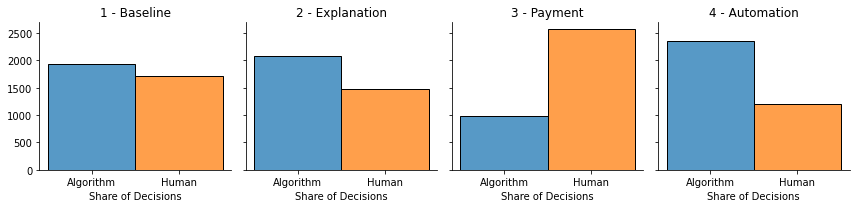

In [121]:
g = sns.FacetGrid(df_experiment_cl, col = 'treatment', hue='delegation_text')
g.map(sns.histplot, 'delegation_text', bins = 2)
g.set_axis_labels("Share of Decisions")
axes = g.axes.flatten()
axes[0].set_title('1 - Baseline')
axes[1].set_title('2 - Explanation')
axes[2].set_title('3 - Payment')
axes[3].set_title('4 - Automation')
plt.tight_layout()

Frequencies of delegation over time:

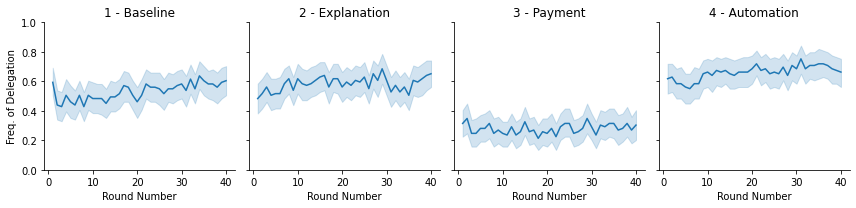

In [122]:
g = sns.FacetGrid(df_experiment_cl, col='treatment')
g.map(sns.lineplot, 'round_number', 'delegated_round')
g.set_axis_labels('Round Number', 'Freq. of Delegation')
g.set(ylim=(0, 1))
axes = g.axes.flatten()
axes[0].set_title('1 - Baseline')
axes[1].set_title('2 - Explanation')
axes[2].set_title('3 - Payment')
axes[3].set_title('4 - Automation')
plt.tight_layout()

Cumulative delegation frequency distribution at round 40 (independent observations):

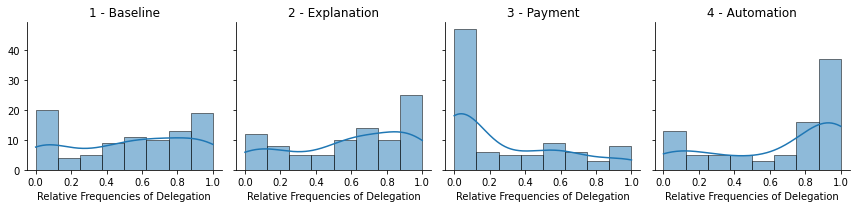

In [123]:
df_experiment_cl2 = df_experiment_cl.loc[df_experiment_cl['round_number']==40]
g = sns.FacetGrid(df_experiment_cl2, col = 'treatment')
g.map(sns.histplot, 'delegated_freq', kde=True, linewidth =0.5, edgecolor='black')
g.set_axis_labels('Relative Frequencies of Delegation')
axes = g.axes.flatten()
axes[0].set_title('1 - Baseline')
axes[1].set_title('2 - Explanation')
axes[2].set_title('3 - Payment')
axes[3].set_title('4 - Automation')
plt.tight_layout()

## 4. Statistical Tests

#### Kruskal-Wallis Test

Application of a Kruskal-Wallis test for the relative delegation frequency at period 40. Each participant's decision history for 40 rounds is considered a single and independent observation. 

The Kruskal-Wallis test is a non-parametric test used to determine if there are differences between three or more independent groups. The test compares the medians of the groups to see if they are statistically different.This test is a non-parametric version of ANOVA since this data do not respect the gaussian distribution shape.

In [124]:
var = 'delegated_freq'

group1 = df_1[var]
group2 = df_2[var]
group3 = df_3[var]
group4 = df_4[var]

Check if distribution is gaussian

In [125]:
def check_normality(*samples):
    for i, sample in enumerate(samples):
        stat, p = shapiro(sample)
        alpha = 0.05
        if p > alpha:
            print(f"Sample {i+1} is normally distributed (p = {p:.5f})")
        else:
            print(f"Sample {i+1} is not normally distributed (p = {p:.5f})")

In [126]:
check_normality(group1, group2, group3, group4)

Sample 1 is not normally distributed (p = 0.00001)
Sample 2 is not normally distributed (p = 0.00001)
Sample 3 is not normally distributed (p = 0.00000)
Sample 4 is not normally distributed (p = 0.00000)


In [127]:
stat, p = kruskal(group1, group2, group3, group4)
print("Kruskal-Wallis test statistic:", stat)
print("p-value:", p)

Kruskal-Wallis test statistic: 52.67438657040321
p-value: 2.1511172074900842e-11


Kruskal-Wallis test statistic is 52.674 and the p-value is very small (p < 0.001). This suggests that there is a significant difference between the medians of the four independent samples being compared.

Violin plot of delegation frequencies across treatments

In [128]:
group1 = group1.reset_index()
group2 = group2.reset_index()
group3 = group3.reset_index()
group4 = group4.reset_index()

group1['treatment'] = 'Baseline'
group2['treatment'] = 'Explanation'
group3['treatment'] = 'Payment'
group4['treatment'] = 'Automation'

groups_cons = pd.concat([group1, group2, group3, group4], ignore_index=True)

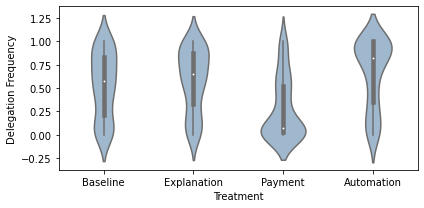

In [129]:
plt.figure(figsize=(6, 3))
boxprops = {'facecolor': 'none', 'edgecolor': 'royalblue'}
whiskerprops = {'linestyle': '--', 'linewidth': 1, 'color': 'black'}
meanprops = {'color': 'red'}

sns.violinplot(x='treatment', y='delegated_freq', data=groups_cons, width=0.5, 
            boxprops = boxprops, whiskerprops = whiskerprops, color = '#97B9D6', alpha = 0.2)

plt.xlabel('Treatment')
plt.ylabel('Delegation Frequency')
plt.tight_layout()

#### Dunn Post-Hoc Test

Dunn's test is a post-hoc test that can be used to identify significant pairwise differences between multiple groups after a Kruskal-Wallis test has been conducted. Dunn's test is a non-parametric test that uses the rank sums of each group to compare the difference between each pair of groups. It is similar to the Mann-Whitney U test, which compares the ranks of two groups. Dunn's test computes a Z score for each pairwise comparison and then converts it to a p-value using a standard normal distribution. The p-values can then be adjusted for multiple comparisons using a method such as the Bonferroni correction.



In [130]:
dunn_results = sp.posthoc_dunn(df_sub_tests, val_col='delegated_freq', group_col='treatment')
dunn_results_formatted = dunn_results.style.format("{:.4f}")
dunn_results_formatted

,3,4,5,7
3,1.0000,0.3729,0.0000,0.0095
4,0.3729,1.0000,0.0000,0.0903
5,0.0000,0.0000,1.0000,0.0000
7,0.0095,0.0903,0.0000,1.0000


The table you have provided shows the p-values obtained from performing Dunn's test on the pairwise comparisons between four groups. We have small p values of all comparisons between 3,4,5 and 7, except for 3 and 4 (baseline and whitebox).

## 5. Correlations

Spearman correlation matrix:

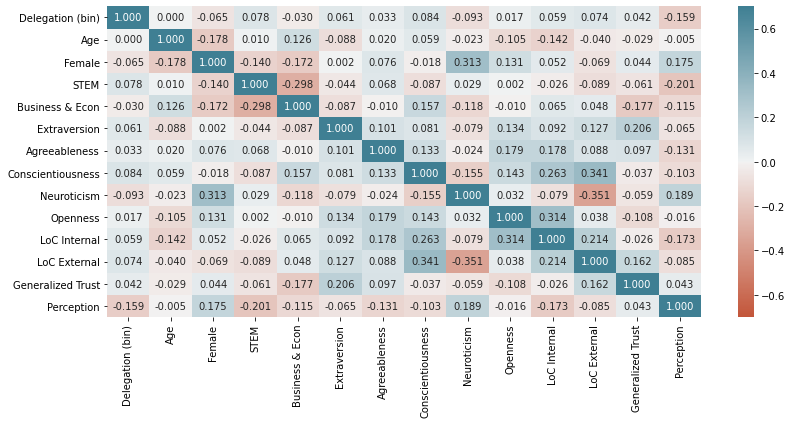

In [131]:
plt.figure(figsize=(12, 6))
correlation_mat = df_merged_filtered_corr_2.corr(method='spearman')
n_colors = 256 
palette = sns.diverging_palette(20, 220, n=n_colors)
sns.heatmap(correlation_mat, annot=True, cmap=palette, vmin=-0.7, vmax=0.7,fmt=".3f")
plt.tight_layout()

Point Biserial Correlation: <br>
A Point Biserial Correlation is a statistical measure that quantifies the association or relationship between a continuous variable and a dichotomous variable

In [132]:
print('Point biserial correlation coefficients:')
print()

binary_var = df_merged['delegation_bin']
numerical_vars = ['age','female','stem','business_econ','extraversion','agreeableness', 
                  'conscientiousness', 'neuroticism', 'openness', 'loc_general','internal_loc',
                  'external_loc','trust','perception']

for var in numerical_vars:
    corr, p_value = pointbiserialr(binary_var, df_merged[var].values)
    print(f"{var}; {corr:.3f}; p:; {p_value:.7f}")

Point biserial correlation coefficients:

age; -0.019; p:; 0.0257426
female; -0.065; p:; 0.0000000
stem; 0.078; p:; 0.0000000
business_econ; -0.030; p:; 0.0004197
extraversion; 0.060; p:; 0.0000000
agreeableness; 0.039; p:; 0.0000031
conscientiousness; 0.089; p:; 0.0000000
neuroticism; -0.087; p:; 0.0000000
openness; 0.024; p:; 0.0048931
loc_general; 0.082; p:; 0.0000000
internal_loc; 0.060; p:; 0.0000000
external_loc; 0.068; p:; 0.0000000
trust; 0.044; p:; 0.0000002
perception; -0.147; p:; 0.0000000


The statistcal significance suggests that this correlations are unlikely to have occurred by chance.

## 6. Regression Analysis

Logistic regression using the binary variable "delegation" and personality traits

In [133]:
# x and y variables definition

dep = ['delegation_bin']


# without interactions
indep = ['explanation_d', 'payment_d', 'automation_d', 'female','age','stem', 'business_econ', 
         'extraversion', 'agreeableness', 'conscientiousness', 'neuroticism', 
         'openness', 'internal_loc','external_loc', 'trust', 'perception']

# with interactions
indep_inter = ['explanation_d', 'payment_d', 'automation_d','female','age','stem','business_econ',
               'extraversion', 'agreeableness', 'conscientiousness', 'neuroticism', 'openness', 
               'internal_loc','external_loc', 'trust', 'perception', 'female_neuroticism_interaction', 
               'locint_conscientiousness_interaction', 'locext_conscientiousness_interaction', 
               'locext_neuroticism_interaction', 'locint_openess_interaction']

Logistic Regression model (with clusterred standard errors on the participant level):

In [134]:
X = sm.add_constant(df_merged[indep])
y = df_merged[dep]
logit_model_s = sm.Logit(y, X)

cluster_var = df_merged['participant_code']
logit_result_s = logit_model_s.fit(cov_type='cluster', cov_kwds={'groups': cluster_var})
logit_result_s.summary()

Optimization terminated successfully.
         Current function value: 0.635590
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:         delegation_bin   No. Observations:                14000
Model:                          Logit   Df Residuals:                    13983
Method:                           MLE   Df Model:                           16
Date:                Wed, 26 Jul 2023   Pseudo R-squ.:                 0.08202
Time:                        13:41:02   Log-Likelihood:                -8898.3
converged:                       True   LL-Null:                       -9693.3
Covariance Type:              cluster   LLR p-value:                     0.000
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.5247      1.013     -0.518      0.605      -2.511       1.461
explanation_d         0.2518      0.207      1.217      0.223      -0.154       0.657
payment_d            -1.0125      0.235     -4.308      0.000      -1.473      -0.552
automation_d          0.5151      0.234      2.205      0.027       0.057       0.973
female               -0.1442      0.179     -0.805      0.421      -0.495       0.207
age                  -0.0094      0.018     -0.530      0.596      -0.044       0.025
stem                  0.2671      0.227      1.179      0.238      -0.177       0.711
business_econ        -0.1806      0.201     -0.897      0.370      -0.575       0.214
extraversion          0.0402      0.059      0.679      0.497      -0.076       0.156
agreeableness         0.0356      0.073      0.487      0.627      -0.108       0.179
conscientiousness     0.1374      0.085      1.618      0.106      -0.029       0.304
neuroticism          -0.0469      0.072     -0.654      0.513      -0.187       0.094
openness             -0.0081      0.087     -0.093      0.926      -0.179       0.163
internal_loc          0.0570      0.102      0.556      0.578      -0.144       0.258
external_loc          0.0536      0.106      0.505      0.614      -0.155       0.262
trust                 0.0673      0.066      1.022      0.307      -0.062       0.196
perception           -0.3679      0.140     -2.626      0.009      -0.642      -0.093
=====================================================================================
"""

Logistic Regression model with interactions (with clusterred standard errors on the participant level):

In [135]:
X = sm.add_constant(df_merged[indep_inter])
y = df_merged[dep]
logit_model_int = sm.Logit(y, X)
logit_result_int = logit_model_int.fit(cov_type='cluster', cov_kwds={'groups': cluster_var})
logit_result_int.summary()

Optimization terminated successfully.
         Current function value: 0.629130
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:         delegation_bin   No. Observations:                14000
Model:                          Logit   Df Residuals:                    13978
Method:                           MLE   Df Model:                           21
Date:                Wed, 26 Jul 2023   Pseudo R-squ.:                 0.09135
Time:                        13:41:02   Log-Likelihood:                -8807.8
converged:                       True   LL-Null:                       -9693.3
Covariance Type:              cluster   LLR p-value:                     0.000
========================================================================================================
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
const                                    5.1947      4.046      1.284      0.199      -2.736      13.125
explanation_d                            0.1949      0.210      0.927      0.354      -0.217       0.607
payment_d                               -1.0531      0.240     -4.395      0.000      -1.523      -0.584
automation_d                             0.4531      0.235      1.929      0.054      -0.007       0.914
female                                   0.8210      0.567      1.449      0.147      -0.289       1.931
age                                     -0.0123      0.018     -0.673      0.501      -0.048       0.024
stem                                     0.2687      0.232      1.161      0.246      -0.185       0.723
business_econ                           -0.1926      0.201     -0.959      0.337      -0.586       0.201
extraversion                             0.0185      0.059      0.312      0.755      -0.098       0.135
agreeableness                            0.0435      0.073      0.595      0.552      -0.100       0.187
conscientiousness                       -0.4109      0.597     -0.689      0.491      -1.580       0.758
neuroticism                              0.1108      0.361      0.307      0.759      -0.597       0.818
openness                                -0.7101      0.416     -1.708      0.088      -1.525       0.105
internal_loc                            -1.2659      0.618     -2.048      0.041      -2.477      -0.054
external_loc                             0.2510      0.604      0.416      0.678      -0.932       1.434
trust                                    0.0701      0.065      1.072      0.284      -0.058       0.198
perception                              -0.3612      0.140     -2.573      0.010      -0.636      -0.086
female_neuroticism_interaction          -0.2339      0.136     -1.726      0.084      -0.499       0.032
locint_conscientiousness_interaction     0.1358      0.089      1.520      0.129      -0.039       0.311
locext_conscientiousness_interaction    -0.0427      0.094     -0.454      0.650      -0.227       0.142
locext_neuroticism_interaction          -0.0106      0.079     -0.133      0.894      -0.166       0.145
locint_openess_interaction               0.1388      0.079      1.751      0.080      -0.017       0.294
========================================================================================================
"""

Quantile Regression model

In [158]:
formula = 'delegated_freq ~ ' + ' + '.join(indep)
model = smf.quantreg(formula, data=df_merged_40)
quantile_regression_median = model.fit(q=.5)
quantile_regression_median.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:         delegated_freq   Pseudo R-squared:               0.1895
Model:                       QuantReg   Bandwidth:                      0.2183
Method:                 Least Squares   Sparsity:                       0.7798
Date:                Wed, 26 Jul 2023   No. Observations:                  350
Time:                        14:00:03   Df Residuals:                      333
                                        Df Model:                           16
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.3856      0.280      1.379      0.169      -0.164       0.936
explanation_d         0.0881      0.059      1.488      0.138      -0.028       0.205
payment_d            -0.3671      0.060     -6.113      0.000      -0.485      -0.249
automation_d          0.1916      0.060      3.174      0.002       0.073       0.310
female               -0.0273      0.046     -0.586      0.558      -0.119       0.064
age                  -0.0030      0.005     -0.635      0.526      -0.012       0.006
stem                  0.0781      0.057      1.367      0.173      -0.034       0.191
business_econ        -0.0513      0.055     -0.941      0.348      -0.159       0.056
extraversion          0.0228      0.017      1.348      0.179      -0.010       0.056
agreeableness         0.0109      0.021      0.528      0.598      -0.030       0.051
conscientiousness     0.0254      0.024      1.071      0.285      -0.021       0.072
neuroticism           0.0017      0.018      0.091      0.927      -0.034       0.037
openness              0.0045      0.023      0.201      0.841      -0.040       0.049
internal_loc         -0.0199      0.027     -0.729      0.467      -0.073       0.034
external_loc          0.0579      0.028      2.061      0.040       0.003       0.113
trust                 0.0132      0.019      0.691      0.490      -0.024       0.051
perception           -0.1430      0.034     -4.158      0.000      -0.211      -0.075
=====================================================================================
"""

Quantile Regression model with interaction terms

In [159]:
formula = 'delegated_freq ~ ' + ' + '.join(indep_inter)
model = smf.quantreg(formula, data=df_merged_40)
quantile_regression_median = model.fit(q=.5)
quantile_regression_median.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:         delegated_freq   Pseudo R-squared:               0.2101
Model:                       QuantReg   Bandwidth:                      0.2112
Method:                 Least Squares   Sparsity:                       0.7473
Date:                Wed, 26 Jul 2023   No. Observations:                  350
Time:                        14:00:07   Df Residuals:                      328
                                        Df Model:                           21
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                                1.2057      1.043      1.156      0.248      -0.846       3.257
explanation_d                            0.0390      0.057      0.681      0.497      -0.074       0.152
payment_d                               -0.3969      0.058     -6.845      0.000      -0.511      -0.283
automation_d                             0.1505      0.058      2.583      0.010       0.036       0.265
female                                   0.1054      0.139      0.756      0.450      -0.169       0.380
age                                     -0.0067      0.005     -1.479      0.140      -0.016       0.002
stem                                     0.1312      0.055      2.391      0.017       0.023       0.239
business_econ                           -0.0343      0.052     -0.656      0.512      -0.137       0.069
extraversion                             0.0109      0.017      0.662      0.509      -0.022       0.043
agreeableness                            0.0151      0.020      0.754      0.451      -0.024       0.055
conscientiousness                        0.0582      0.166      0.350      0.727      -0.269       0.385
neuroticism                              0.0204      0.086      0.236      0.814      -0.150       0.190
openness                                -0.2198      0.103     -2.133      0.034      -0.422      -0.017
internal_loc                            -0.2579      0.144     -1.793      0.074      -0.541       0.025
external_loc                             0.1796      0.157      1.145      0.253      -0.129       0.488
trust                                    0.0078      0.018      0.424      0.672      -0.029       0.044
perception                              -0.1024      0.033     -3.077      0.002      -0.168      -0.037
female_neuroticism_interaction          -0.0323      0.033     -0.974      0.331      -0.097       0.033
locint_conscientiousness_interaction     0.0155      0.026      0.602      0.548      -0.035       0.066
locext_conscientiousness_interaction    -0.0254      0.025     -1.024      0.307      -0.074       0.023
locext_neuroticism_interaction          -0.0028      0.018     -0.152      0.879      -0.039       0.033
locint_openess_interaction               0.0407      0.020      2.061      0.040       0.002       0.079
========================================================================================================

The condition number is large, 2.93e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## 7. Reaction Analysis

In [136]:
grouped = df_merged_sorted.groupby('treatment').agg({'strat_reaction': 'sum', 'delegated_plus_scored': lambda x: sum(x == 1)})
result = grouped['strat_reaction'] / grouped['delegated_plus_scored']
print('Frequency Reaction:')
print(result)

Frequency Reaction:
treatment
3    0.303430
4    0.244019
5    0.345622
7    0.086560
dtype: float64


In [137]:
# gender split

df_merged_male = df_merged_sorted.loc[df_merged_sorted['gender_num']==1]
df_merged_female = df_merged_sorted.loc[df_merged_sorted['gender_num']==2]

In [138]:
grouped = df_merged_male.groupby('treatment').agg({'strat_reaction': 'sum', 'delegated_plus_scored': lambda x: sum(x == 1)})
result_male = grouped['strat_reaction'] / grouped['delegated_plus_scored']
print('Frequency Reaction (Male):')
print(result_male)

Frequency Reaction (Male):
treatment
3    0.264249
4    0.152174
5    0.273684
7    0.069767
dtype: float64


In [139]:
grouped = df_merged_female.groupby('treatment').agg({'strat_reaction': 'sum', 'delegated_plus_scored': lambda x: sum(x == 1)})
result_female = grouped['strat_reaction'] / grouped['delegated_plus_scored']
print('Frequency Reaction (Female):')
print(result_female)

Frequency Reaction (Female):
treatment
3    0.344086
4    0.316239
5    0.401639
7    0.102679
dtype: float64


In [140]:
result = result.reset_index()
result_male = result_male.reset_index()
result_female = result_female.reset_index()
result.rename(columns={0:'strat_reaction'}, inplace=True)
result_male.rename(columns={0:'strat_reaction'}, inplace=True)
result_female.rename(columns={0:'strat_reaction'}, inplace=True)
result['split'] = 'Aggregated'
result_male['split'] = 'Male'
result_female['split'] = 'Female'
results_all = pd.concat([result, result_male, result_female])

treat_dict = {
    3:'Baseline',
    4:'Explanation',
    5:'Payment',
    7:'Automation'
    }

results_all["treat_string"] = results_all["treatment"].map(treat_dict)

In [141]:
df_merged_sorted['strat_reaction_cum'] = df_merged_sorted.groupby('participant_code')['strat_reaction'].cumsum()
df_merged_sorted['delegated_plus_scored_cum'] = df_merged_sorted.groupby('participant_code')['delegated_plus_scored'].cumsum()
df_merged_sorted['strat_reaction_freq'] = df_merged_sorted['strat_reaction_cum'] / df_merged_sorted['delegated_plus_scored_cum']

In [142]:
df_merged_sorted_fg = df_merged_sorted.loc[df_merged_sorted['gender_num']<=2]
df_merged_sorted_fg2 = df_merged_sorted_fg.copy()

df_merged_sorted_fg2['gender'] = 'Aggregated'
df_all = pd.concat([df_merged_sorted_fg, df_merged_sorted_fg2])
df_all = df_all.reset_index()

Time-series reaction frequencies

Text(0.5, 1.0, 'Aggregated')

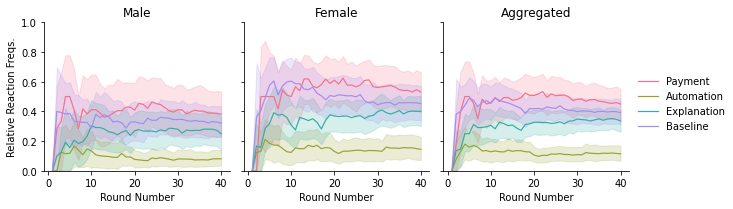

In [143]:
g = sns.FacetGrid(df_all, col = 'gender', hue='treat_string', palette='husl')
g.map(sns.lineplot, 'round_number', 'strat_reaction_freq', linewidth=1.2)
g.set_axis_labels('Round Number','Relative Reaction Freqs.')
g.set(ylim=(0, 1))
axes = g.axes.flatten()
g.add_legend(title='')
axes[0].set_title('Male')
axes[1].set_title('Female')
axes[2].set_title('Aggregated')

Statistical tests - Mann-Whitney U

In [144]:
df_merged_sorted_lr = df_merged_sorted.loc[df_merged_sorted['round_number']==40]
df_merged_sorted_lr_m = df_merged_sorted_lr.loc[df_merged_sorted_lr['gender_num']==1]
df_merged_sorted_lr_f = df_merged_sorted_lr.loc[df_merged_sorted_lr['gender_num']==2]

In [145]:
sample_male = df_merged_sorted_lr_m['strat_reaction_freq']
sample_female = df_merged_sorted_lr_f['strat_reaction_freq']

sample_male_clean = pd.to_numeric(sample_male, errors='coerce')
sample_female_clean = pd.to_numeric(sample_female, errors='coerce')

sample_male_clean = sample_male_clean.replace([np.inf, -np.inf], np.nan).dropna()
sample_female_clean = sample_female_clean.replace([np.inf, -np.inf], np.nan).dropna()

In [146]:
check_normality(sample_male_clean, sample_female_clean)

Sample 1 is not normally distributed (p = 0.00000)
Sample 2 is not normally distributed (p = 0.00000)


In [147]:
mwu, pvalue = mannwhitneyu(sample_male_clean, sample_female_clean)
print('Mann-Whitney U statistic:', mwu)
print('p-value:', pvalue)

Mann-Whitney U statistic: 7751.5
p-value: 0.0027792128266977373


In [148]:
# dealing with inf and nan values
column_name = 'strat_reaction_freq'

infinite_rows = df_merged_sorted_lr_f[column_name].apply(lambda x: np.isinf(x))
infinite_row_indices = infinite_rows[infinite_rows].index
df_merged_sorted_lr_f = df_merged_sorted_lr_f.drop(infinite_row_indices)

In [149]:
df_merged_sorted_lr_f = df_merged_sorted_lr.loc[df_merged_sorted_lr['gender_num']<=2]

Male and female reaction frequencies per treatment

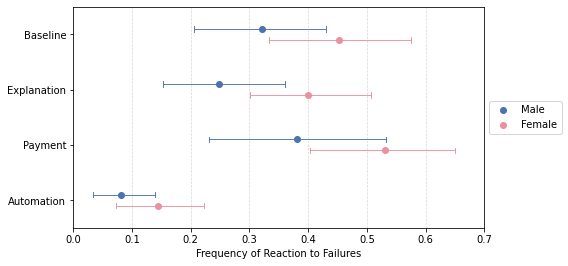

In [155]:
plt.figure(figsize=(8, 3.8))
order = ['Baseline', 'Explanation', 'Payment', 'Automation']

custom_dodge = 0.2
ax = sns.pointplot(data=df_merged_sorted_lr_f, x="strat_reaction_freq", y="treat_string", hue="gender",
                   palette=[ '#4c72b0', '#EA909F'],scale = 0.8,  capsize=.1, join=False, dodge = custom_dodge, 
                   order=order)

for line in ax.lines:
    line.set_linewidth(1)
    line.set_alpha(0.9)

ax.legend(title=None, loc='center left', bbox_to_anchor=(1, 0.5))
ax.xaxis.grid(True, linestyle='--', alpha=0.5, linewidth = 0.7)
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.1))

ax.set_xlim(0,0.7)
ax.set_xlabel('Frequency of Reaction to Failures')
ax.set_ylabel('')
plt.tight_layout()

Logit regression on the binary variable "reaction" using the whole dataset

In [80]:
indep_r = ['explanation_d', 'payment_d', 'automation_d', 'female','age','stem', 'business_econ',
           'extraversion', 'agreeableness', 'conscientiousness', 'neuroticism', 
           'openness', 'internal_loc','external_loc', 'trust', 'perception']

dep_r = ['strat_reaction']

In [81]:
df_merged_sorted.reset_index()
df = df_merged_sorted
X = sm.add_constant(df[indep_r])
y = df[dep_r]
logit_model = sm.Logit(y, X)
result_logit =  logit_model.fit(cov_type='cluster', cov_kwds={'groups': cluster_var})
result_logit.summary()

Optimization terminated successfully.
         Current function value: 0.108545
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:         strat_reaction   No. Observations:                14000
Model:                          Logit   Df Residuals:                    13983
Method:                           MLE   Df Model:                           16
Date:                Mon, 24 Jul 2023   Pseudo R-squ.:                 0.02764
Time:                        16:25:22   Log-Likelihood:                -1519.6
converged:                       True   LL-Null:                       -1562.8
Covariance Type:              cluster   LLR p-value:                 1.154e-11
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -2.1877      0.868     -2.520      0.012      -3.889      -0.486
explanation_d        -0.0880      0.181     -0.488      0.626      -0.442       0.266
payment_d            -0.3204      0.214     -1.499      0.134      -0.739       0.098
automation_d         -1.0419      0.240     -4.334      0.000      -1.513      -0.571
female                0.4529      0.154      2.940      0.003       0.151       0.755
age                   0.0046      0.016      0.286      0.775      -0.027       0.036
stem                 -0.3448      0.213     -1.616      0.106      -0.763       0.073
business_econ         0.0209      0.182      0.115      0.908      -0.336       0.378
extraversion          0.0305      0.053      0.572      0.567      -0.074       0.135
agreeableness         0.1209      0.081      1.484      0.138      -0.039       0.281
conscientiousness     0.0268      0.082      0.327      0.743      -0.134       0.187
neuroticism          -0.0443      0.061     -0.730      0.465      -0.163       0.075
openness              0.0399      0.090      0.444      0.657      -0.136       0.216
internal_loc         -0.2917      0.087     -3.361      0.001      -0.462      -0.122
external_loc         -0.1068      0.104     -1.028      0.304      -0.310       0.097
trust                -0.0339      0.070     -0.482      0.630      -0.172       0.104
perception           -0.2292      0.122     -1.882      0.060      -0.468       0.009
=====================================================================================
"""

## 8. Reinforcement Learning Performance

Probability of selecting the high-probability product generated by the reinforcement learning update

Text(0.5, 1.0, '4 - Automation')

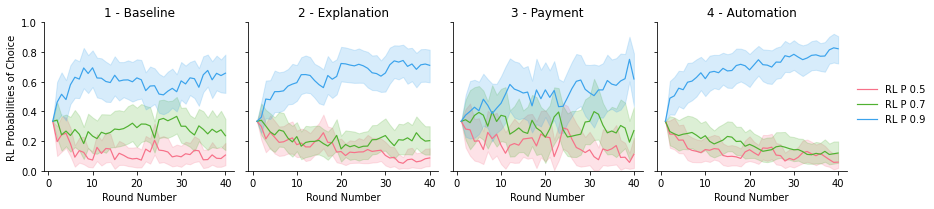

In [82]:
g = sns.FacetGrid(probs_df, col = 'treatment', hue='var', palette='husl')
g.map(sns.lineplot, 'round_number', 'value', linewidth=1.2)
g.set_axis_labels('Round Number',"RL Probabilities of Choice")
g.set(ylim=(0, 1))
axes = g.axes.flatten()
g.add_legend(title='')
axes[0].set_title('1 - Baseline')
axes[1].set_title('2 - Explanation')
axes[2].set_title('3 - Payment')
axes[3].set_title('4 - Automation')

Frequency of Payoffs

In [83]:
df = df_merged
df['algo_performance'] = ((df['delegation'] == 1) & (df['payoff_round'] == 1)).astype(int)
df['human_performance'] = ((df['delegation'] == 2) & (df['payoff_round'] == 1)).astype(int)
df_algo = df[df['delegation'] == 1]
df_human = df[df['delegation'] == 2]
algo_performance_freq = df_algo.groupby(['treat_string', 'round_number'])['algo_performance'].mean()
human_performance_freq = df_human.groupby(['treat_string', 'round_number'])['human_performance'].mean()

In [84]:
print('Frequency scored - Algorithm:')
print(df_algo.groupby(['treat_string'])['algo_performance'].mean())

Frequency scored - Algorithm:
treat_string
Automation     0.808881
Baseline       0.803627
Explanation    0.797872
Payment        0.778345
Name: algo_performance, dtype: float64


In [85]:
print('Frequency scored - Human:')
print(df_human.groupby(['treat_string'])['human_performance'].mean())

Frequency scored - Human:
treat_string
Automation     0.771767
Baseline       0.754386
Explanation    0.754821
Payment        0.744225
Name: human_performance, dtype: float64


Frequency of choosing the "high" product

In [86]:
df = df_merged_sorted
df['human_high'] = ((df['delegation'] == 2) & (df['prob_selected'] == 0.9)).astype(int)
df_human_high = df[df['delegation'] == 2]
df['algo_high'] = ((df['delegation'] == 1) & (df['prob_selected'] == 0.9)).astype(int)
df_algo_high = df[df['delegation'] == 1]

In [87]:
print('Frequency high product - Algorithm:')
print(df_algo_high.groupby(['treat_string'])['algo_high'].mean())

Frequency high product - Algorithm:
treat_string
Automation     0.694384
Baseline       0.591710
Explanation    0.634429
Payment        0.505618
Name: algo_high, dtype: float64


In [88]:
print('Frequency high product - Human:')
print(df_human_high.groupby(['treat_string'])['human_high'].mean())

Frequency high product - Human:
treat_string
Automation     0.514793
Baseline       0.511111
Explanation    0.495179
Payment        0.505250
Name: human_high, dtype: float64
